In [1]:
# Imports
import pandas as pd
import numpy as np
import random
import seaborn as sns
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Definir a semente aleatória para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Carregando os Dados

In [3]:
# Carregar o dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

## Modelo 1: Redistribuição de recuros financeiros baseada nas Emissões de CO2e

In [4]:
# Variáveis iniciais
states = data['UF']
emissions = data['emissoesCO2e'].values
financing = data['totalFinanciado'].values

In [5]:
# Soma total de financiamento disponível
total_financing = financing.sum()

In [6]:
# Distribuir o financiamento proporcionalmente às emissões de CO2e
proportional_financing = (emissions / emissions.sum()) * total_financing

In [7]:
# Adicionar os resultados ao DataFrame
data['FinalFinancing_M1'] = proportional_financing

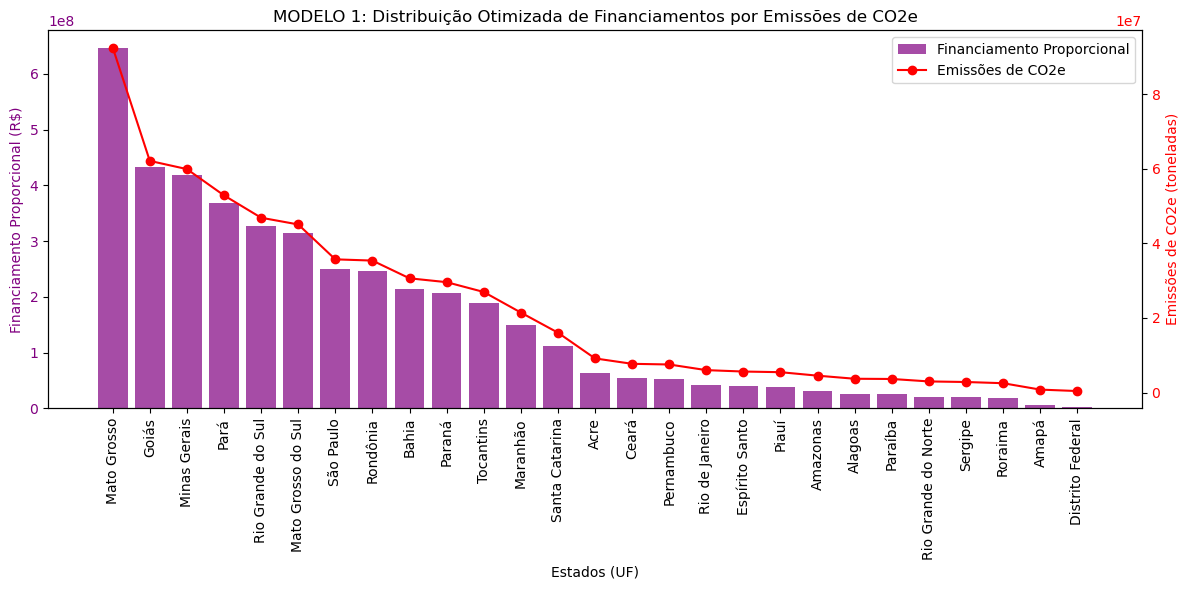

In [8]:
# Visualizar a distribuição proporcional
def plot_proportional_distribution(data):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Gráfico de barras para 'ProportionalFinancing'
    ax1.bar(data['UF'], data['FinalFinancing_M1'], color='purple', alpha=0.7, label='Financiamento Proporcional')
    ax1.set_xlabel('Estados (UF)')
    ax1.set_ylabel('Financiamento Proporcional (R$)', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.set_title('MODELO 1: Distribuição Otimizada de Financiamentos por Emissões de CO2e')

    # Gráfico de linha para 'emissoesCO2e'
    ax2 = ax1.twinx()
    ax2.plot(data['UF'], data['emissoesCO2e'], color='red', marker='o', label='Emissões de CO2e')
    ax2.set_ylabel('Emissões de CO2e (toneladas)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Legendas
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    # Configurar os rótulos do eixo X com rotação vertical
    ax1.set_xticks(range(len(data['UF'])))
    ax1.set_xticklabels(data['UF'], rotation=90)

    plt.tight_layout()
    plt.show()

plot_proportional_distribution(data)

## Modelo 2: Redistribuição de recuros financeiros baseada na Otimização Multiobjetivo

In [9]:
import os
import sys
from deap import base, creator, tools, algorithms

In [10]:
# Variáveis do problema
emissoes = data['emissoesCO2e'].values
populacao_rural = data['populacao'].values
total_financiado = data['totalFinanciado'].values
total_recursos = np.sum(total_financiado)
n_states = len(total_financiado)

In [11]:
# Normalização Min-Max das variáveis
emissoes_min, emissoes_max = np.min(emissoes), np.max(emissoes)
populacao_rural_min, populacao_rural_max = np.min(populacao_rural), np.max(populacao_rural)

def normalize(value, vmin, vmax):
    return (value - vmin) / (vmax - vmin)

emissoes_norm = normalize(emissoes, emissoes_min, emissoes_max)
populacao_rural_norm = normalize(populacao_rural, populacao_rural_min, populacao_rural_max)

In [12]:
# Definir o problema de otimização multi-objetivo com DEAP
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar ambos os objetivos
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

In [13]:
# Inicialização dos indivíduos: valores de financiamento entre 0 e o total permitido
toolbox.register("attr_float", random.uniform, 0, max(total_financiado))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_states)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [14]:
# Função de avaliação
def evaluate(individual):
    # Garantir que a soma total seja próxima ao orçamento total
    scaling_factor = total_recursos / sum(individual)
    scaled_individual = [x * scaling_factor for x in individual]
    
    # Objetivo 1: Minimizar emissões normalizadas
    f1 = sum((emissoes_norm / total_financiado) * scaled_individual)
    
    # Objetivo 2: Maximizar população normalizada (negativo para alinhamento)
    f2 = -sum((populacao_rural_norm / total_financiado) * scaled_individual)
    
    return f1, f2

In [15]:
# Função de restrição: soma próxima ao orçamento total
def feasible(individual):
    return abs(sum(individual) - total_recursos) < 1e-3

In [16]:
# Registrar a função de avaliação
toolbox.register("evaluate", evaluate)

In [17]:
# Decorar a função de avaliação com a penalização
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 1e6))

In [18]:
# Operadores genéticos
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=max(total_financiado), eta=20, indpb=0.2)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)

In [19]:
# Parâmetros do algoritmo
population_size = 100
generations = 100
mutation_prob = 0.2
crossover_prob = 0.7

In [20]:
# Inicializar a população
population = toolbox.population(n=population_size)

In [21]:
# Redirecionar saída padrão para evitar mensagens no console
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Aplicar NSGA-II com supressão da saída
with HiddenPrints():
    algorithms.eaMuPlusLambda(population, toolbox,
                              mu=population_size,
                              lambda_=population_size,
                              cxpb=crossover_prob,
                              mutpb=mutation_prob,
                              ngen=generations,
                              stats=None,
                              halloffame=None,
                              verbose=True)

In [22]:
# Extrair o fronte de Pareto
pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

In [23]:
# Exibir uma solução eficiente
best_solution = pareto_front[0]
scaling_factor = total_recursos / sum(best_solution)
optimal_allocation = [x * scaling_factor for x in best_solution]
data['FinalFinancing_M2'] = optimal_allocation
print("Distribuição Otimizada dos Recursos:")
print(data[['UF', 'FinalFinancing_M2']])

Distribuição Otimizada dos Recursos:
                     UF  FinalFinancing_M2
0           Mato Grosso       2.472883e+08
1                 Goiás       9.672519e+06
2          Minas Gerais       1.063633e+08
3                  Pará       8.632327e+07
4     Rio Grande do Sul       2.848188e+08
5    Mato Grosso do Sul       2.617030e+08
6             São Paulo       3.450365e+08
7              Rondônia       3.362224e+07
8                 Bahia       1.631717e+08
9                Paraná       1.152361e+07
10            Tocantins       8.455483e+07
11             Maranhão       1.954383e+08
12       Santa Catarina       1.026237e+07
13                 Acre       7.689736e+07
14                Ceará       2.513327e+08
15           Pernambuco       2.107476e+08
16       Rio de Janeiro       8.525197e+07
17       Espírito Santo       2.278893e+08
18                Piauí       3.130346e+08
19             Amazonas       2.513294e+06
20              Alagoas       3.116380e+08
21              P

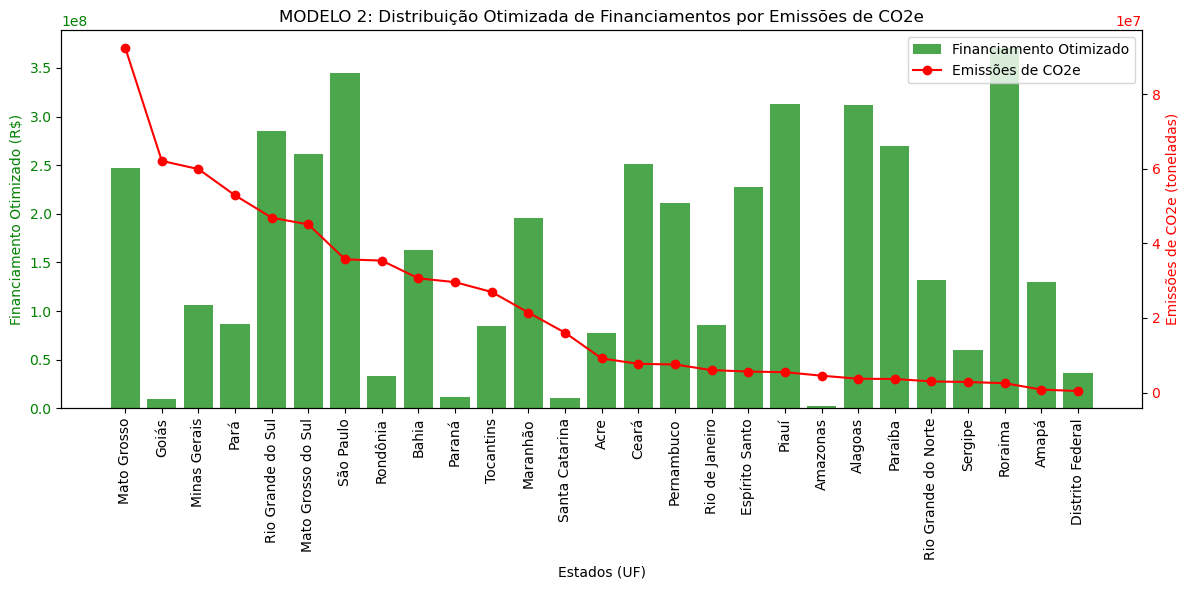

In [24]:
# Visualizar a distribuição proporcional
def plot_proportional_distribution(data):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Gráfico de barras para 'ProportionalFinancing'
    ax1.bar(data['UF'], data['FinalFinancing_M2'], color='green', alpha=0.7, label='Financiamento Otimizado')
    ax1.set_xlabel('Estados (UF)')
    ax1.set_ylabel('Financiamento Otimizado (R$)', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_title('MODELO 2: Distribuição Otimizada de Financiamentos por Emissões de CO2e')

    # Gráfico de linha para 'emissoesCO2e'
    ax2 = ax1.twinx()
    ax2.plot(data['UF'], data['emissoesCO2e'], color='red', marker='o', label='Emissões de CO2e')
    ax2.set_ylabel('Emissões de CO2e (toneladas)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Legendas
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    # Configurar os rótulos do eixo X com rotação vertical
    ax1.set_xticks(range(len(data['UF'])))
    ax1.set_xticklabels(data['UF'], rotation=90)

    plt.tight_layout()
    plt.show()

plot_proportional_distribution(data)

## Modelo 3: Redistribuição de recuros financeiros por meio de heurística baseada em regras e eficiência

In [25]:
# Variáveis iniciais
states = data['UF']
emissions = data['emissoesCO2e'].values
contracts = data['qtdContratos'].values
financing = data['totalFinanciado'].values
total_financing = data['totalFinanciado'].sum()

In [26]:
# Modelo 1: Distribuição Proporcional às Emissões
proportional_financing = (emissions / emissions.sum()) * total_financing
data['ProportionalFinancing'] = proportional_financing

In [27]:
# Calcular Eficiência
efficiency = financing / proportional_financing
data['Efficiency'] = efficiency

In [28]:
# Ajustar Pesos para Impacto Social/Econômico (Contratos por Financiamento)
impact_social = contracts / proportional_financing
data['ImpactSocial'] = impact_social

In [29]:
# Criar uma métrica combinada de eficiência e impacto social
data['CombinedScore'] = (data['Efficiency'] + data['ImpactSocial']) / 2

In [30]:
# Redistribuir os recursos proporcionalmente ao CombinedScore
adjusted_financing = (data['CombinedScore'] / data['CombinedScore'].sum()) * total_financing

In [31]:
# Garantir que os valores estejam entre 70% e 130% do financiamento proporcional
lower_bound = 0.7 * proportional_financing
upper_bound = 1.3 * proportional_financing

In [32]:
# Aplicar as restrições
final_financing = np.clip(adjusted_financing, lower_bound, upper_bound)

In [33]:
# Ajustar para garantir que a soma total seja exatamente igual ao orçamento total
scaling_factor = total_financing / final_financing.sum()
final_financing = final_financing * scaling_factor

In [34]:
# Adicionar os resultados ao DataFrame
data['FinalFinancing_M3'] = final_financing

In [35]:
# Exibir os resultados
data[['UF', 'ProportionalFinancing', 'Efficiency', 'ImpactSocial', 'FinalFinancing_M3']]

,UF,ProportionalFinancing,Efficiency,ImpactSocial,FinalFinancing_M3
0,Mato Grosso,6.460794e+08,1.386653,5.355379e-07,5.017915e+08
1,Goiás,4.337754e+08,0.771664,3.711598e-07,3.369010e+08
2,Minas Gerais,4.184329e+08,1.776574,1.610772e-06,4.754383e+08
3,Pará,3.691860e+08,0.345305,3.737953e-07,2.867363e+08
4,Rio Grande do Sul,3.273882e+08,1.292455,6.353315e-07,3.458803e+08
5,Mato Grosso do Sul,3.147880e+08,1.234094,7.560645e-07,3.302623e+08
6,São Paulo,2.494477e+08,1.341342,9.500989e-07,3.589635e+08
7,Rondônia,2.471457e+08,0.276367,3.965272e-07,1.919510e+08
8,Bahia,2.139414e+08,1.564734,1.266702e-06,3.085869e+08
9,Paraná,2.067300e+08,0.574056,6.336766e-07,1.605613e+08


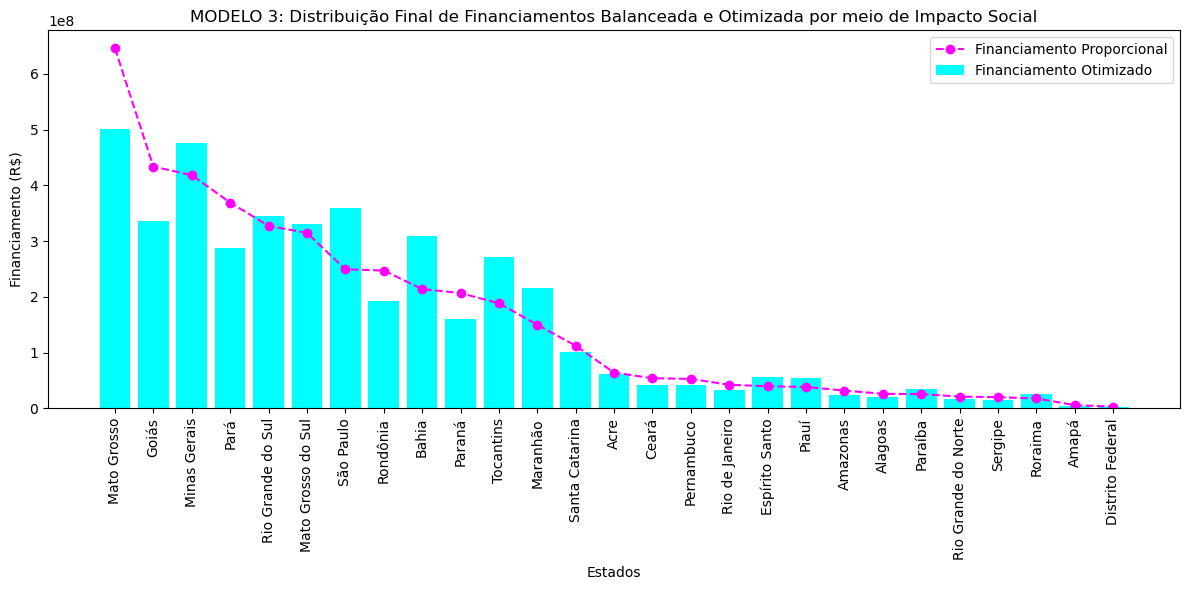

In [36]:
# Visualizar os resultados
plt.figure(figsize=(12, 6))
plt.bar(data['UF'], data['FinalFinancing_M3'], color='aqua', label='Financiamento Otimizado')
plt.plot(data['UF'], data['ProportionalFinancing'], color='magenta', marker='o', linestyle='--', label='Financiamento Proporcional')
plt.xticks(rotation=90)
plt.xlabel('Estados')
plt.ylabel('Financiamento (R$)')
plt.title('MODELO 3: Distribuição Final de Financiamentos Balanceada e Otimizada por meio de Impacto Social')
plt.legend()
plt.tight_layout()
plt.show()

## Modelo 4: Redistribuição de recuros financeiros por meio de heurística baseada em regras e eficiência com incorporação de variáveis

In [37]:
# Variáveis iniciais
states = data['UF']
emissions = data['emissoesCO2e'].values
contracts = data['qtdContratos'].values
area_financed = data['areaFinanciada'].values  # Área financiada (gerar um impacto adicional)
population_rural = data['populacao'].values  # População rural (gerar um impacto adicional)
financing = data['totalFinanciado'].values
total_financing = data['totalFinanciado'].sum()

In [38]:
# Modelo 1: Distribuição Proporcional às Emissões
proportional_financing = (emissions / emissions.sum()) * total_financing
data['ProportionalFinancing'] = proportional_financing

In [39]:
# Calcular Eficiência
efficiency = financing / proportional_financing
data['Efficiency'] = efficiency

In [40]:
# Calcular o Índice de Impacto Social
# Normalizar as variáveis ajustadas pelo financiamento proporcional
contracts_norm = contracts / proportional_financing
population_norm = population_rural / proportional_financing
area_norm = area_financed / proportional_financing

In [41]:
# Pesos ajustáveis
w1, w2, w3 = 0.05, 0.9, 0.05  # Ajuste conforme prioridades

In [42]:
# Cálculo do índice
data['ImpactSocial'] = (
    w1 * contracts_norm +
    w2 * population_norm +
    w3 * area_norm
)

In [43]:
# Criar a métrica combinada ponderada
data['CombinedScore'] = (
    0.5 * data['Efficiency'] +  # Peso para eficiência
    0.5 * data['ImpactSocial']  # Peso para impacto social
)

In [44]:
# Redistribuir os recursos proporcionalmente ao CombinedScore
adjusted_financing = (data['CombinedScore'] / data['CombinedScore'].sum()) * total_financing

In [45]:
# Garantir que os valores estejam entre 70% e 130% do financiamento proporcional
lower_bound = 0.7 * proportional_financing
upper_bound = 1.3 * proportional_financing

In [46]:
# Aplicar as restrições
final_financing = np.clip(adjusted_financing, lower_bound, upper_bound)

In [47]:
# Ajustar para garantir que a soma total seja exatamente igual ao orçamento total
scaling_factor = total_financing / final_financing.sum()
final_financing = final_financing * scaling_factor

In [48]:
# Adicionar os resultados ao DataFrame
data['FinalFinancing_M4'] = final_financing

In [49]:
# Exibir os resultados
data[['UF', 'ProportionalFinancing', 'Efficiency', 'ImpactSocial', 'FinalFinancing_M4']]

,UF,ProportionalFinancing,Efficiency,ImpactSocial,FinalFinancing_M4
0,Mato Grosso,6.460794e+08,1.386653,0.000718,5.041343e+08
1,Goiás,4.337754e+08,0.771664,0.001005,3.384740e+08
2,Minas Gerais,4.184329e+08,1.776574,0.005214,4.702819e+08
3,Pará,3.691860e+08,0.345305,0.004939,2.880751e+08
4,Rio Grande do Sul,3.273882e+08,1.292455,0.003751,3.421179e+08
5,Mato Grosso do Sul,3.147880e+08,1.234094,0.000951,3.259754e+08
6,São Paulo,2.494477e+08,1.341342,0.005106,3.553790e+08
7,Rondônia,2.471457e+08,0.276367,0.001239,1.928472e+08
8,Bahia,2.139414e+08,1.564734,0.013863,3.100277e+08
9,Paraná,2.067300e+08,0.574056,0.005510,1.613110e+08


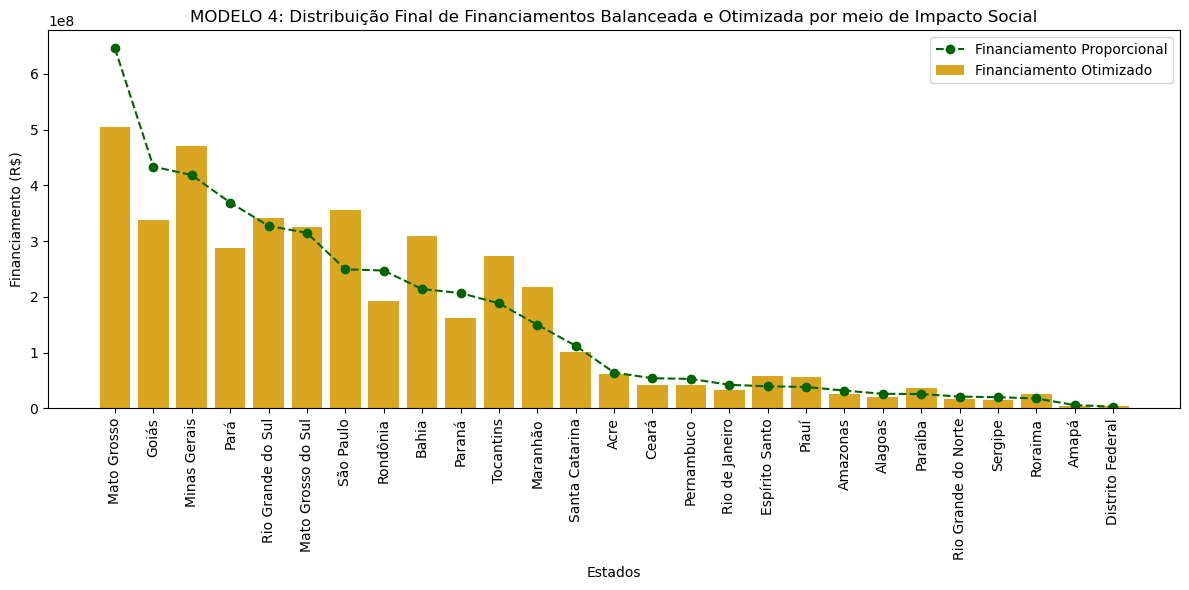

In [50]:
# Visualizar os resultados
plt.figure(figsize=(12, 6))
plt.bar(data['UF'], data['FinalFinancing_M4'], color='goldenrod', label='Financiamento Otimizado')
plt.plot(data['UF'], data['ProportionalFinancing'], color='darkgreen', marker='o', linestyle='--', label='Financiamento Proporcional')
plt.xticks(rotation=90)
plt.xlabel('Estados')
plt.ylabel('Financiamento (R$)')
plt.title('MODELO 4: Distribuição Final de Financiamentos Balanceada e Otimizada por meio de Impacto Social')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# Remover colunas desnecessárias para a análise
data.drop(['ProportionalFinancing', 'Efficiency', 'ImpactSocial', 'CombinedScore'], axis = 1, inplace = True)

In [52]:
data

,UF,emissoesCO2e,populacao,qtdContratos,totalFinanciado,areaFinanciada,FinalFinancing_M1,FinalFinancing_M2,FinalFinancing_M3,FinalFinancing_M4
0,Mato Grosso,9.245920e+07,502120,346.0,8.958880e+08,244768.85,6.460794e+08,2.472883e+08,5.017915e+08,5.041343e+08
1,Goiás,6.207678e+07,480391,161.0,3.347290e+08,73834.96,4.337754e+08,9.672519e+06,3.369010e+08,3.384740e+08
2,Minas Gerais,5.988115e+07,2418095,674.0,7.433772e+08,110545.68,4.184329e+08,1.063633e+08,4.754383e+08,4.702819e+08
3,Pará,5.283352e+07,2024601,138.0,1.274818e+08,26470.31,3.691860e+08,8.632327e+07,2.867363e+08,2.880751e+08
4,Rio Grande do Sul,4.685190e+07,1359872,208.0,4.231343e+08,81323.01,3.273882e+08,2.848188e+08,3.458803e+08,3.421179e+08
5,Mato Grosso do Sul,4.504871e+07,327142,238.0,3.884781e+08,98017.03,3.147880e+08,2.617030e+08,3.302623e+08,3.259754e+08
6,São Paulo,3.569799e+07,1413339,237.0,3.345948e+08,34015.51,2.494477e+08,3.450365e+08,3.589635e+08,3.553790e+08
7,Rondônia,3.536855e+07,339524,98.0,6.830295e+07,12936.81,2.471457e+08,3.362224e+07,1.919510e+08,1.928472e+08
8,Bahia,3.061675e+07,3291488,271.0,3.347613e+08,69763.15,2.139414e+08,1.631717e+08,3.085869e+08,3.100277e+08
9,Paraná,2.958475e+07,1264533,131.0,1.186747e+08,18660.80,2.067300e+08,1.152361e+07,1.605613e+08,1.613110e+08


## Visualização resumida

In [53]:
# Remover colunas desnecessárias para a análise
data.drop(['emissoesCO2e', 'populacao', 'qtdContratos', 'areaFinanciada'], axis = 1, inplace = True)

In [54]:
data

,UF,totalFinanciado,FinalFinancing_M1,FinalFinancing_M2,FinalFinancing_M3,FinalFinancing_M4
0,Mato Grosso,8.958880e+08,6.460794e+08,2.472883e+08,5.017915e+08,5.041343e+08
1,Goiás,3.347290e+08,4.337754e+08,9.672519e+06,3.369010e+08,3.384740e+08
2,Minas Gerais,7.433772e+08,4.184329e+08,1.063633e+08,4.754383e+08,4.702819e+08
3,Pará,1.274818e+08,3.691860e+08,8.632327e+07,2.867363e+08,2.880751e+08
4,Rio Grande do Sul,4.231343e+08,3.273882e+08,2.848188e+08,3.458803e+08,3.421179e+08
5,Mato Grosso do Sul,3.884781e+08,3.147880e+08,2.617030e+08,3.302623e+08,3.259754e+08
6,São Paulo,3.345948e+08,2.494477e+08,3.450365e+08,3.589635e+08,3.553790e+08
7,Rondônia,6.830295e+07,2.471457e+08,3.362224e+07,1.919510e+08,1.928472e+08
8,Bahia,3.347613e+08,2.139414e+08,1.631717e+08,3.085869e+08,3.100277e+08
9,Paraná,1.186747e+08,2.067300e+08,1.152361e+07,1.605613e+08,1.613110e+08


# Fim